In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
# module imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import os


Data extraction****
here we upload our dataset

In [27]:
import os

folder_path = 'C:/Users/quiet/Documents/jupyter/CS240/NSL-KDD'
#folder_path = '/content/drive/MyDrive/CS240/NSL-KDD'
#files = os.listdir(folder_path)

train_file = 'KDDTrain+.txt'
train_path = os.path.join(folder_path, train_file)
data_train = pd.read_csv(train_path)
# data_train.head()

test_file = 'KDDTest+.txt'
test_path = os.path.join(folder_path, test_file)
data_test = pd.read_csv(test_path)

print("Length of training set: ", len(data_train))
print("Length of testing set: ", len(data_test))

Length of training set:  125972
Length of testing set:  22543


In [28]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])
data_train.columns = columns
data_test.columns = columns


In [29]:
data_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


**Data transformations**
I adding a column that encodes 'normal' values as 0 and any other value as 1. We will use this as our classifier for a simple binary model that idenfities any attack.

In [30]:
# map normal to 0, all attacks to 1
is_attack = data_train.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = data_test.attack.map(lambda a: 0 if a == 'normal' else 1)

#data_with_attack = df.join(is_attack, rsuffix='_flag')
data_train['attack_flag'] = is_attack
data_test['attack_flag'] = test_attack

# view the result
#data.head()

In [31]:
data_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag
0,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1


In [32]:
data_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21,1
1,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.04,0.61,0.02,0.00,0.0,0.00,0.00,normal,21,0
2,0,icmp,eco_i,SF,20,0,0,0,0,0,...,0.00,1.00,0.28,0.00,0.0,0.00,0.00,saint,15,1
3,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.17,0.03,0.02,0.00,0.0,0.83,0.71,mscan,11,1
4,0,tcp,http,SF,267,14515,0,0,0,0,...,0.00,0.01,0.03,0.01,0.0,0.00,0.00,normal,21,0


attack_flag
0    0.534579
1    0.465421
Name: proportion, dtype: float64

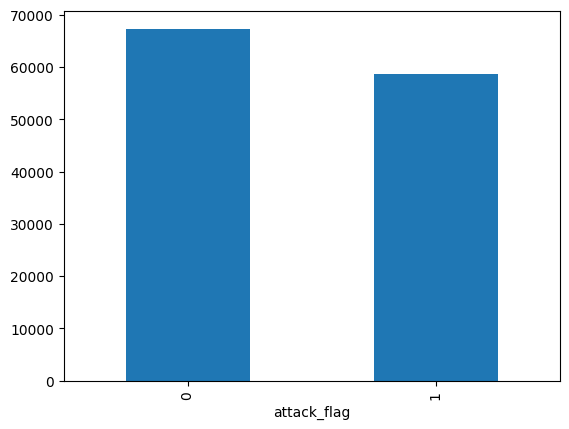

In [33]:
data_train['attack_flag'].value_counts().plot.bar()
data_train['attack_flag'].value_counts(normalize=True)

attack_flag
1    0.569223
0    0.430777
Name: proportion, dtype: float64

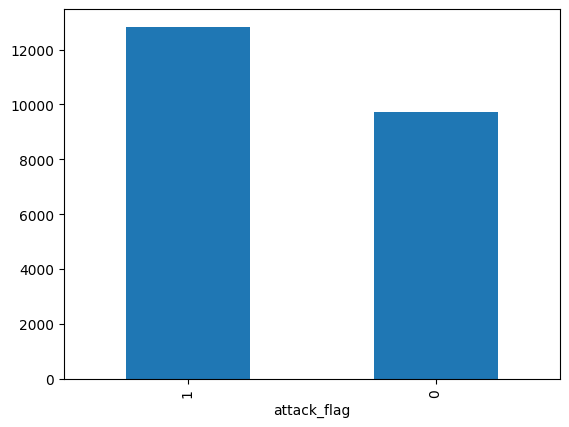

In [34]:
data_test['attack_flag'].value_counts().plot.bar()
data_test['attack_flag'].value_counts(normalize=True)

I classify each of the attacks according to attack type for a more granular prediction model.

In [35]:
# lists to hold our attack classifications
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
U2R = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
Sybil = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

# we will use these for plotting below
attack_labels = ['Normal','DoS','Probe','U2R','Sybil']

# helper function to pass to data frame mapping
def map_attack(attack):
    if attack in dos_attacks:
        # dos_attacks map to 1
        attack_type = 1
    elif attack in probe_attacks:
        # probe_attacks mapt to 2
        attack_type = 2
    elif attack in U2R:
        # privilege escalation attacks map to 3
        attack_type = 3
    elif attack in Sybil:
        # remote access attacks map to 4
        attack_type = 4
    else:
        # normal maps to 0
        attack_type = 0

    return attack_type

# map the data and join to the data set
attack_map = data_train.attack.apply(map_attack)
data_train['attack_map'] = attack_map

test_attack_map = data_test.attack.apply(map_attack)
data_test['attack_map'] = test_attack_map

**Data profiling**
i put in table of attack by protocol.

In [36]:
# attack vs MCS protocols
attack_vs_protocol = pd.crosstab(data_train.attack, data_train.protocol_type)
attack_vs_protocol

protocol_type,icmp,tcp,udp
attack,,,
back,0,956,0
buffer_overflow,0,30,0
ftp_write,0,8,0
guess_passwd,0,53,0
imap,0,11,0
ipsweep,3117,482,0
land,0,18,0
loadmodule,0,9,0
multihop,0,7,0


**Visual Representation of Dataset**
 see how things are distributed.

In [37]:
# helper function for drawing mulitple charts.
def bake_pies(data_list,labels):
    list_length = len(data_list)

    # setup for mapping colors
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}

    # build the subplots
    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)

    # loop through the data sets and build the charts
    for count, data_set in enumerate(data_list):

        # update our color mapt with new values
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)

        # build the wedges
        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])

        # build the legend
        axs[count].legend(wedges, data_set.index,
                           title="Flags",
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
        # set the title
        axs[count].set_title(labels[count])

    return axs



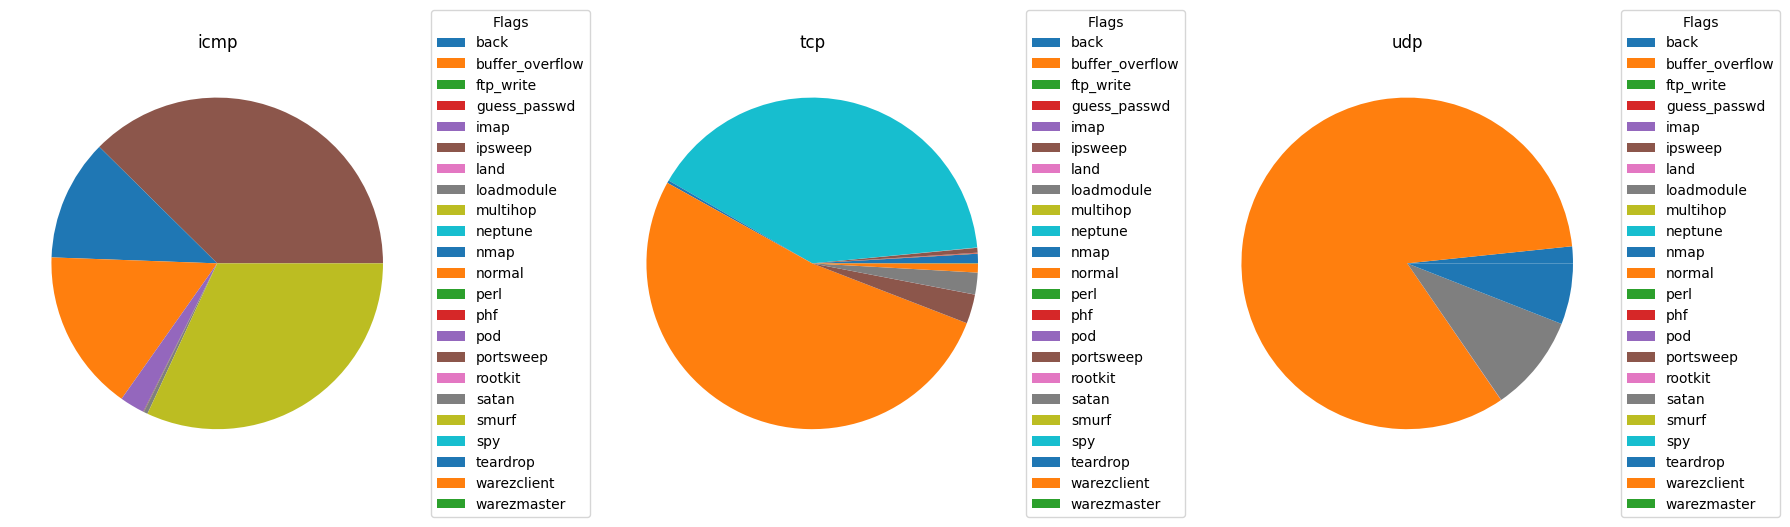

In [38]:
# get the series for each protocol
icmp_attacks = attack_vs_protocol.icmp
tcp_attacks = attack_vs_protocol.tcp
udp_attacks = attack_vs_protocol.udp

# create the charts
bake_pies([icmp_attacks, tcp_attacks, udp_attacks],['icmp','tcp','udp'])
plt.show()

Our monitoring strategy uses a series continuous network protocols and capable of learning subtle distinction between threats and legal ones. Historical information fed the machine learning model classify Sybil and other attacks (ddos, probe, u2r). It helps to identify recurring patterns of Sybil, DDoS, U2R, Probe attacks and locate in long-term traffic chain.

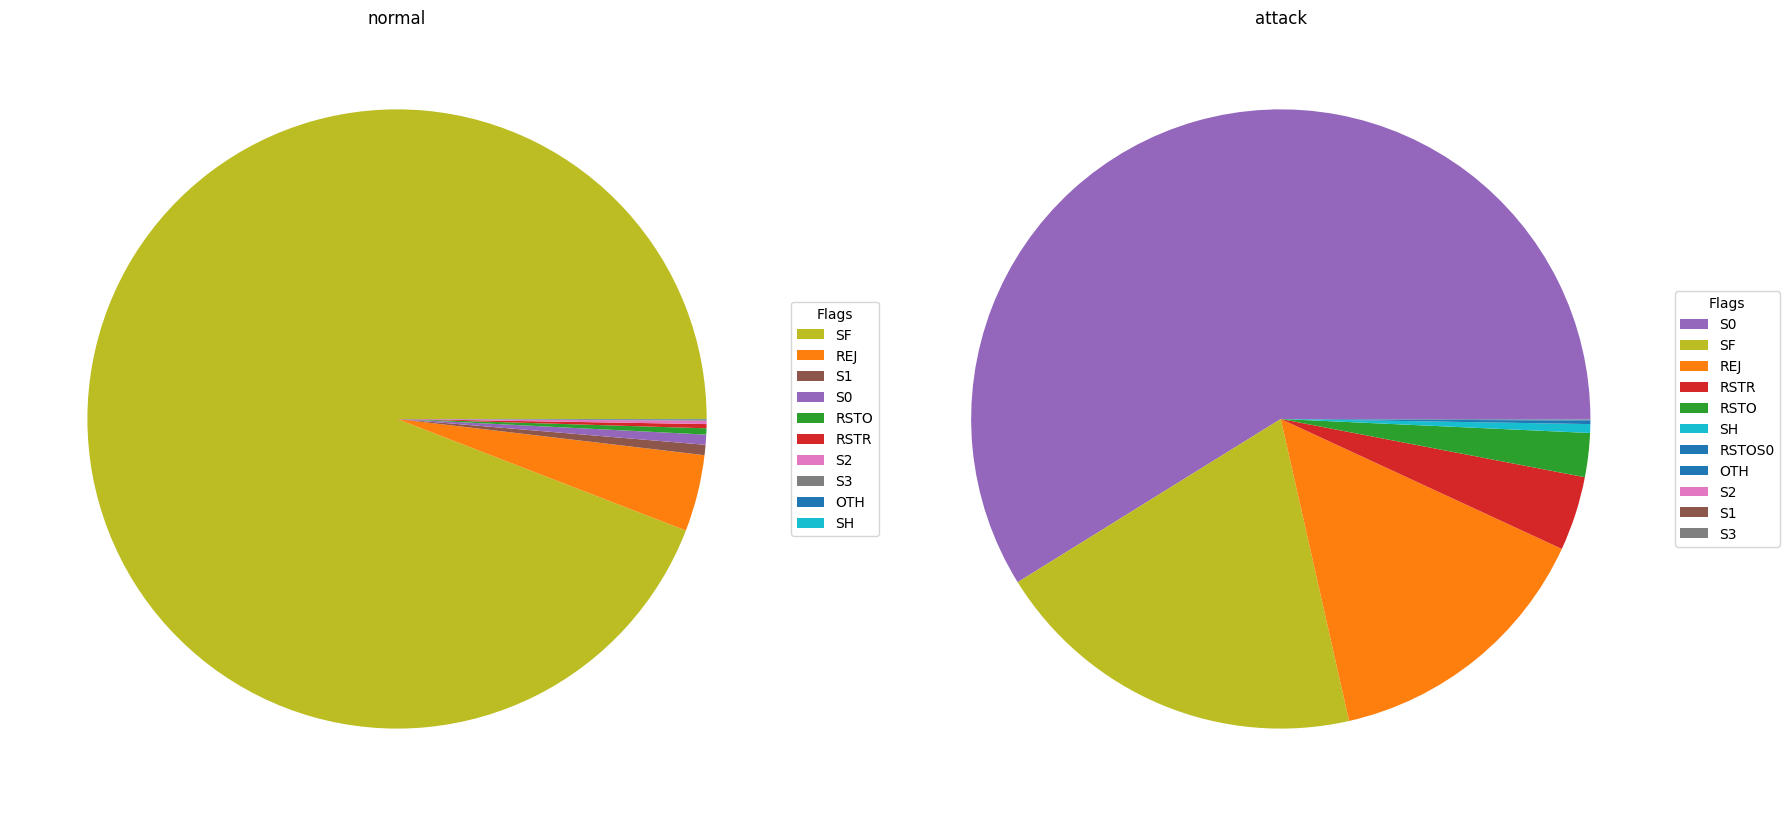

In [39]:
# get a series with the count of each flag for attack and normal traffic
normal_flags = data_train.loc[data_train.attack_flag == 0].flag.value_counts()
attack_flags =data_train.loc[data_train.attack_flag == 1].flag.value_counts()

# create the charts
flag_axs = bake_pies([normal_flags, attack_flags], ['normal','attack'])
plt.show()

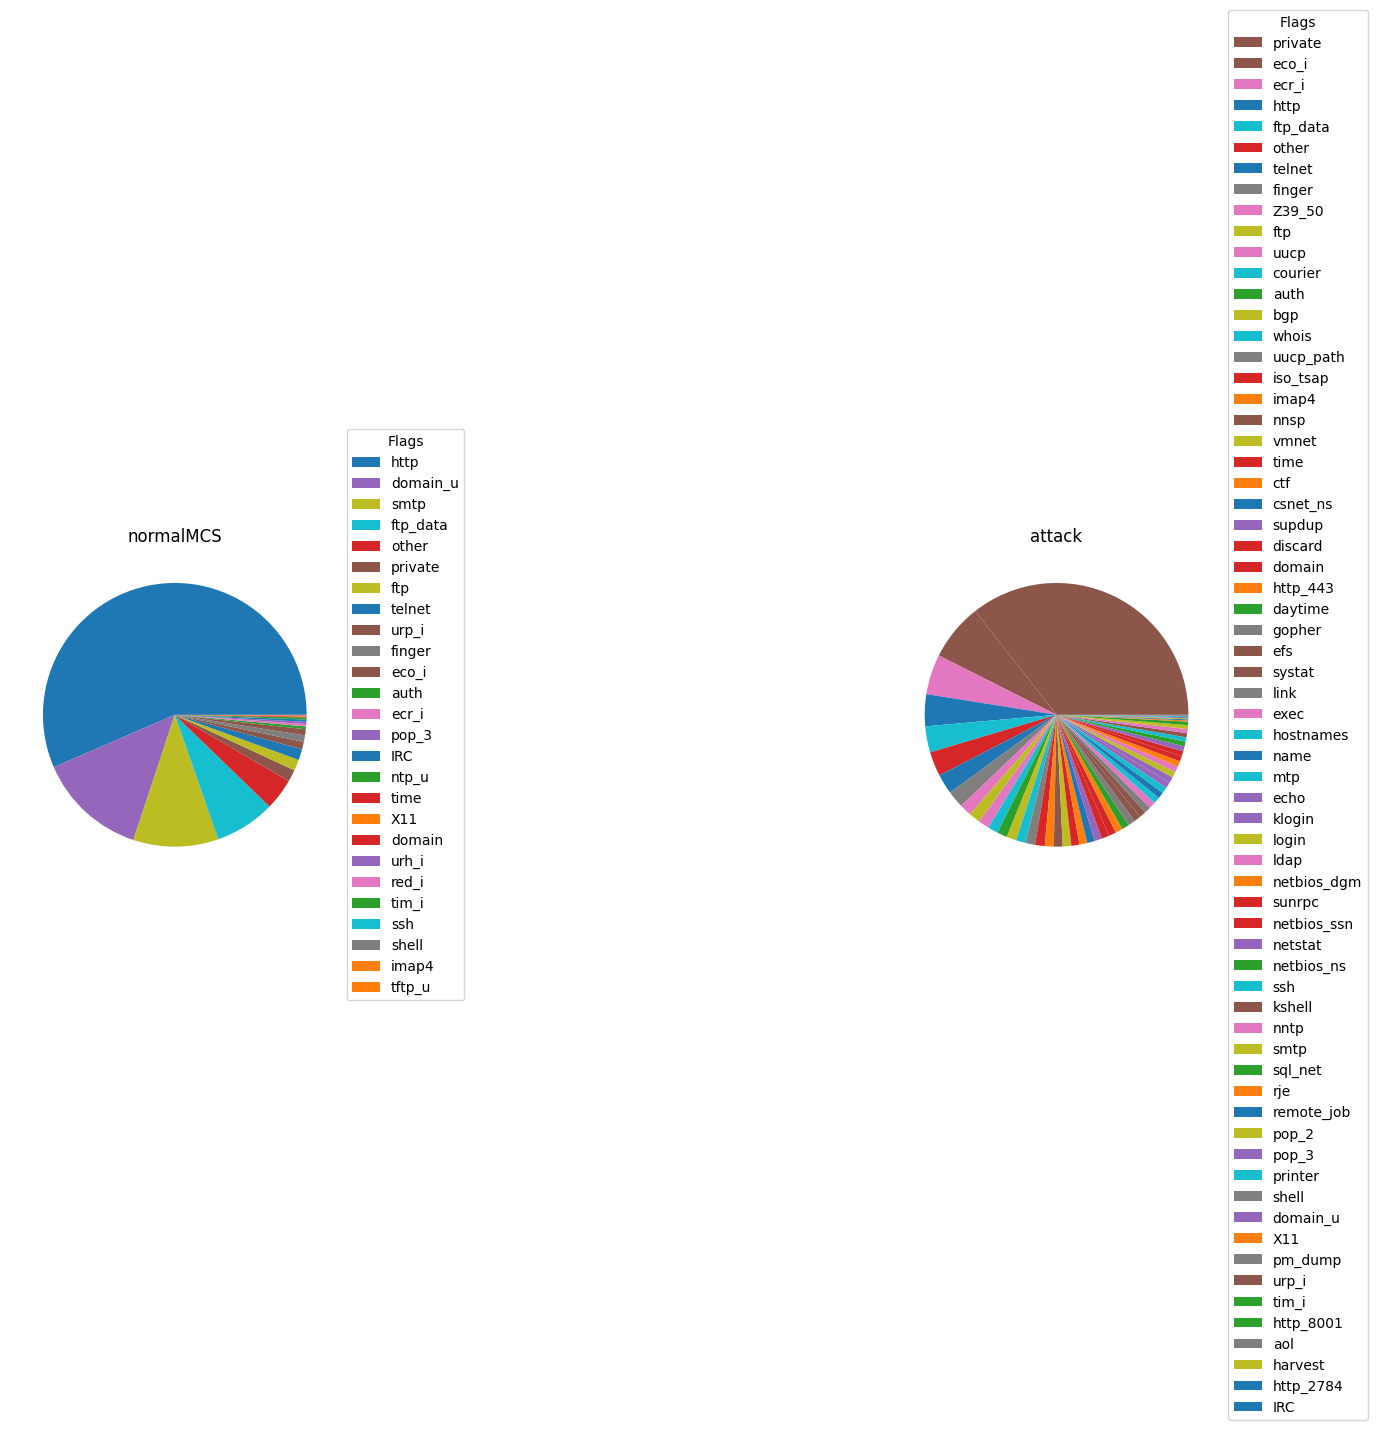

In [40]:
# get a series with the count of each service for attack and normal MCS
normal_services = data_train.loc[data_train.attack_flag == 0].service.value_counts()
attack_services = data_train.loc[data_train.attack_flag == 1].service.value_counts()

# create the charts
service_axs = bake_pies([normal_services, attack_services], ['normalMCS','attack'])
plt.show()


Our data show that huge normal traffic is http, our attack traffic is all over the MCS. Sybil ttacks are searching for many different paths into MCS systems; some well traveled and some not.



**Feature engineering**


In [41]:
df = pd.concat([data_train, data_test])
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,attack_map
0,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1,1


In [42]:
df_cat = df.select_dtypes(exclude=[np.number])
print(df_cat.columns)
for feature in df_cat.columns:
    df[feature] = LabelEncoder().fit_transform(df[feature])

Index(['protocol_type', 'service', 'flag', 'attack'], dtype='object')


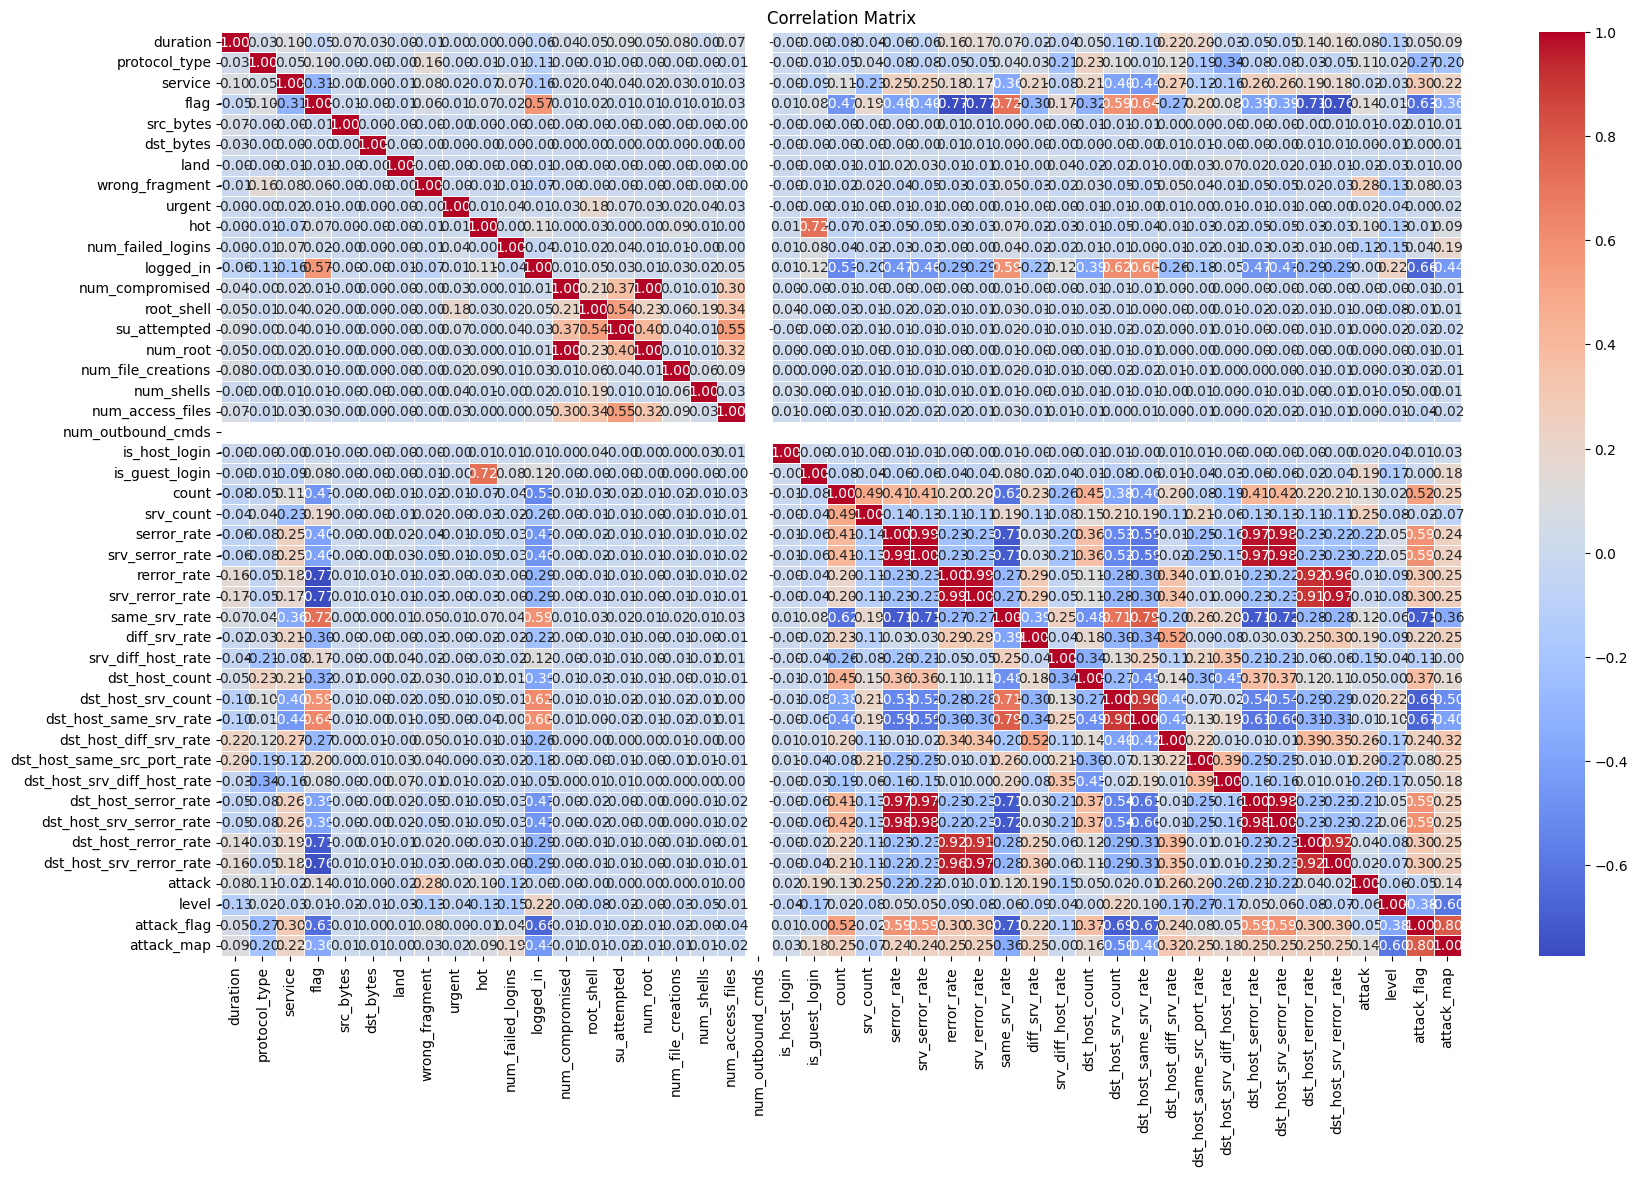

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming corr_matrix is your correlation matrix
plt.figure(figsize=(20, 12))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()


In [44]:
import numpy as np

# Set the threshold for correlation
threshold = 0.95

corr_matrix = df.corr()
# Find the highly correlated variables
correlated_vars = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            correlated_vars.add((colname_j))
            print(f"Correlation between {colname_i} and {colname_j}: {corr_matrix.iloc[i, j]}")

# Print the number of highly correlated pairs
print("Number of highly correlated pairs:", len(correlated_vars))
print(correlated_vars)

Correlation between num_compromised and num_root: 0.9987247769091253
Correlation between serror_rate and srv_serror_rate: 0.9915070293624476
Correlation between serror_rate and dst_host_serror_rate: 0.9746961375901955
Correlation between serror_rate and dst_host_srv_serror_rate: 0.9760303434617954
Correlation between srv_serror_rate and dst_host_serror_rate: 0.9708018218887585
Correlation between srv_serror_rate and dst_host_srv_serror_rate: 0.9819823619122965
Correlation between rerror_rate and srv_rerror_rate: 0.9860945327614858
Correlation between rerror_rate and dst_host_srv_rerror_rate: 0.9573561564434296
Correlation between srv_rerror_rate and dst_host_srv_rerror_rate: 0.9656048075698501
Correlation between dst_host_serror_rate and dst_host_srv_serror_rate: 0.9828120697026873
Number of highly correlated pairs: 6
{'dst_host_serror_rate', 'dst_host_srv_rerror_rate', 'srv_rerror_rate', 'dst_host_srv_serror_rate', 'srv_serror_rate', 'num_root'}


In [45]:
df = df.drop(columns=correlated_vars)
fruitydf = df.sample(n=1000, random_state=42)

In [46]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_rerror_rate,attack,level,attack_flag,attack_map
0,0,2,44,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.0,16,15,0,0
1,0,1,49,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,0.0,14,19,1,1
2,0,1,24,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.0,16,21,0,0
3,0,1,24,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,16,21,0,0
4,0,1,49,1,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,1.0,14,21,1,1


In [18]:
X = df.drop(columns=['attack', 'level', 'attack_flag', 'attack_map'])
feature_list = list(X.columns)
X = np.array(X)
y = df['attack_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [19]:
print("Training set:", len(X_train))
print("Testing set:", len(X_test))

Training set: 118812
Testing set: 29703


In [20]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.optim.lr_scheduler as lr_scheduler

# Define your neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(30, 15)
        self.fc4 = nn.Linear(15, 5)
        self.fc5 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [9]:
import torch
import torch.nn as nn
from torchviz import make_dot

# Define your neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(30, 15)
        self.fc4 = nn.Linear(15, 5)
        self.fc5 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Instantiate your neural network
input_dim = 10  # Example input dimension
model = NeuralNetwork(input_dim)

# Visualize the neural network
x = torch.randn(1, input_dim)  # Example input tensor
make_dot(model(x), params=dict(model.named_parameters()))


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [92]:
# Define input dimension
input_dim = X_train.shape[1]
batch_size = 64
epochs = 50


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to GPU
model = NeuralNetwork(input_dim).to(device)

# Convert your data to PyTorch tensors and move to GPU
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train.values).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test.values).to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters())
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Define your dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Train your model
total_batches = len(train_loader)
# Define early stopping parameters
early_stopping_rounds = 5
best_val_loss = float('inf')
best_epoch = 0
early_stopping_counter = 0

In [93]:
# Train your model
print("Using device: ", device)
for epoch in range(epochs):
    running_loss = 0.0
    val_loss = 0.0
    with tqdm(total=total_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss / (i+1)})
            pbar.update(1)

        # Calculate validation loss
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            val_loss = criterion(test_outputs, y_test_tensor)
            print(f"Train loss: {running_loss/(i+1)} Validation loss : {val_loss}")
            scheduler.step(val_loss)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_rounds:
                print(f'Early stopping triggered! No improvement in validation loss for {early_stopping_rounds} consecutive epochs.')
                break

print('Training completed!')

# Evaluate your model
with torch.no_grad():
    train_outputs = model(X_train_tensor)
    train_loss = criterion(train_outputs, y_train_tensor)
    train_acc = (train_outputs.argmax(dim=1) == y_train_tensor).float().mean()

    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    test_acc = (test_outputs.argmax(dim=1) == y_test_tensor).float().mean()

print(f'Train: Loss: {train_loss.item()}, Accuracy: {train_acc.item()}')
print(f'Validation: Loss: {test_loss.item()}, Accuracy: {test_acc.item()}')
print(f'Best Validation Loss: {best_val_loss.item()} at Epoch {best_epoch+1}')


Using device:  cuda


Epoch 1/50: 100%|███████████████████████████████████████████████████| 1857/1857 [00:21<00:00, 88.19batch/s, loss=0.102]


Train loss: 0.10151468262660147 Validation loss : 0.05859403312206268


Epoch 2/50: 100%|██████████████████████████████████████████████████| 1857/1857 [00:22<00:00, 80.99batch/s, loss=0.0504]


Train loss: 0.050360463968240926 Validation loss : 0.047195784747600555


Epoch 3/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:17<00:00, 107.99batch/s, loss=0.0429]


Train loss: 0.04294514923364498 Validation loss : 0.04330854117870331


Epoch 4/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:13<00:00, 138.02batch/s, loss=0.0403]


Train loss: 0.040254934554730025 Validation loss : 0.039814360439777374


Epoch 5/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:13<00:00, 134.22batch/s, loss=0.0375]


Train loss: 0.03751887702513496 Validation loss : 0.03902288153767586


Epoch 6/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:13<00:00, 134.10batch/s, loss=0.0353]


Train loss: 0.03533963658802405 Validation loss : 0.03538638353347778


Epoch 7/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:13<00:00, 138.70batch/s, loss=0.0342]


Train loss: 0.034239725303838925 Validation loss : 0.03939168527722359


Epoch 8/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:16<00:00, 113.10batch/s, loss=0.0352]


Train loss: 0.03515436046519961 Validation loss : 0.03518730774521828


Epoch 9/50: 100%|██████████████████████████████████████████████████| 1857/1857 [00:19<00:00, 95.83batch/s, loss=0.0315]


Train loss: 0.03152044471207225 Validation loss : 0.03663037344813347


Epoch 10/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:19<00:00, 96.70batch/s, loss=0.0309]


Train loss: 0.030900567091244016 Validation loss : 0.03676873818039894


Epoch 11/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:18<00:00, 98.52batch/s, loss=0.0301]


Train loss: 0.030127144310015064 Validation loss : 0.038711607456207275


Epoch 12/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:19<00:00, 96.76batch/s, loss=0.0296]


Train loss: 0.029640051894676413 Validation loss : 0.03396481275558472


Epoch 13/50: 100%|██████████████████████████████████████████████████| 1857/1857 [00:19<00:00, 94.46batch/s, loss=0.029]


Train loss: 0.028955819774893005 Validation loss : 0.03359336033463478


Epoch 14/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:19<00:00, 94.19batch/s, loss=0.0284]


Train loss: 0.028365198958752398 Validation loss : 0.0333126075565815


Epoch 15/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:19<00:00, 94.70batch/s, loss=0.0277]


Train loss: 0.027747336608011302 Validation loss : 0.03283384069800377


Epoch 16/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:21<00:00, 88.31batch/s, loss=0.0272]


Train loss: 0.027164758270279532 Validation loss : 0.0329618863761425


Epoch 17/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:20<00:00, 89.95batch/s, loss=0.0269]


Train loss: 0.026851865091928075 Validation loss : 0.032990962266922


Epoch 18/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:20<00:00, 92.57batch/s, loss=0.0264]


Train loss: 0.02642345926384046 Validation loss : 0.03351174667477608


Epoch 19/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:20<00:00, 91.19batch/s, loss=0.0254]


Train loss: 0.02542785128807237 Validation loss : 0.032786350697278976


Epoch 20/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:21<00:00, 87.32batch/s, loss=0.0256]


Train loss: 0.025617455160234014 Validation loss : 0.0343613438308239


Epoch 21/50: 100%|██████████████████████████████████████████████████| 1857/1857 [00:20<00:00, 89.19batch/s, loss=0.025]


Train loss: 0.025031189735228505 Validation loss : 0.03491701930761337


Epoch 22/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:20<00:00, 89.08batch/s, loss=0.0245]


Train loss: 0.02448789656580279 Validation loss : 0.034889087080955505


Epoch 23/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:20<00:00, 89.32batch/s, loss=0.0241]


Train loss: 0.02414066202767695 Validation loss : 0.034319378435611725


Epoch 24/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:20<00:00, 89.67batch/s, loss=0.0212]


Train loss: 0.021156239462842424 Validation loss : 0.0321098193526268


Epoch 25/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:21<00:00, 87.85batch/s, loss=0.0207]


Train loss: 0.020667200415768142 Validation loss : 0.03299884870648384


Epoch 26/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:20<00:00, 90.58batch/s, loss=0.0202]


Train loss: 0.020217521700343615 Validation loss : 0.03326311707496643


Epoch 27/50: 100%|██████████████████████████████████████████████████| 1857/1857 [00:16<00:00, 113.40batch/s, loss=0.02]


Train loss: 0.020009602412187938 Validation loss : 0.035227637737989426


Epoch 28/50: 100%|████████████████████████████████████████████████| 1857/1857 [00:13<00:00, 142.45batch/s, loss=0.0197]


Train loss: 0.019714874375636182 Validation loss : 0.034526195377111435


Epoch 29/50: 100%|████████████████████████████████████████████████| 1857/1857 [00:13<00:00, 141.85batch/s, loss=0.0183]


Train loss: 0.018317079245661436 Validation loss : 0.032698649913072586
Early stopping triggered! No improvement in validation loss for 5 consecutive epochs.
Training completed!
Train: Loss: 0.017187854275107384, Accuracy: 0.9935949444770813
Validation: Loss: 0.032698649913072586, Accuracy: 0.9916507005691528
Best Validation Loss: 0.0321098193526268 at Epoch 24


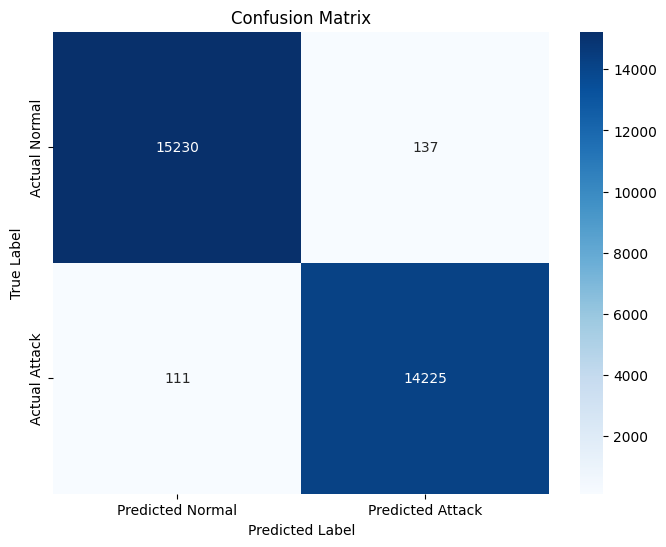

In [94]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get predictions on test data
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    y_pred = test_outputs.argmax(dim=1).cpu().numpy()

# Convert true labels tensor to numpy array
y_true = y_test_tensor.cpu().numpy()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define labels for heatmap
xticklabels = ['Predicted Normal', 'Predicted Attack']
yticklabels = ['Actual Normal', 'Actual Attack']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [95]:
# Calculate false positives and false negatives from the test set confusion matrix
false_positives = cm[0, 1]  # Predicted 1, but actually 0
false_negatives = cm[1, 0]  # Predicted 0, but actually 1

# Calculate total actual positives and total actual negatives
total_positives = np.sum(cm[1, :])  # Total actual positives
total_negatives = np.sum(cm[0, :])  # Total actual negatives

# Calculate percentages
false_positive_rate = (false_positives / total_negatives) * 100
false_negative_rate = (false_negatives / total_positives) * 100

print("False Positive Rate:", false_positive_rate, "%")
print("False Negative Rate:", false_negative_rate, "%")


False Positive Rate: 0.8915207913060454 %
False Negative Rate: 0.7742745535714286 %


In [23]:
X_1 = fruitydf.drop(columns=['attack', 'level', 'attack_flag'])
feature_list = list(X_1.columns)
X_1 = np.array(X)
y_1 = df['attack_flag']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size = 0.2)

In [24]:
scaler = StandardScaler().fit(X_train_1)
X_train_1 = scaler.transform(X_train_1)
X_test_1 = scaler.transform(X_test_1)

# Fruit Fly Feature Selection

In [28]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define parameters for FFOA
num_fruit_flies = 50
num_generations = 100
max_features = X_train.shape[1]
num_selected_features = 10  # New: Number of selected features

# Define fitness function
def fitness(features):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train[:, features], y_train)
    y_pred = clf.predict(X_test[:, features])
    return accuracy_score(y_test, y_pred)

# Initialize population with only 10 selected features
population = np.zeros((num_fruit_flies, max_features), dtype=bool)
for i in range(num_fruit_flies):
    population[i, np.random.choice(max_features, num_selected_features, replace=False)] = True

for generation in range(num_generations):
    fitness_scores = np.array([fitness(features) for features in population])
    elite_flies = population[np.argsort(fitness_scores)][-10:]
    new_population = []
    for _ in range(num_fruit_flies):
        parents = elite_flies[np.random.choice(elite_flies.shape[0], size=2)]
        crossover_point = np.random.randint(0, max_features)
        child = np.hstack((parents[0, :crossover_point], parents[1, crossover_point:]))
        mutation_rate = 0.1
        mutation_mask = np.random.rand(max_features) < mutation_rate
        child[mutation_mask] = ~child[mutation_mask]
        new_population.append(child)
    population = np.array(new_population)

best_fruit_fly = elite_flies[-1]
selected_features = np.where(best_fruit_fly)[0][:num_selected_features]  # Select only the first 10 features
print("Selected Features:", selected_features)

Generation: 0 Progress - Fitness Calculation: 0.0 %
Generation: 0 Progress - Fitness Calculation: 0.0 %
Generation: 0 Progress - Fitness Calculation: 0.0 %
Generation: 0 Progress - Fitness Calculation: 0.0 %
Generation: 0 Progress - Fitness Calculation: 0.0 %
Generation: 0 Progress - Fitness Calculation: 0.0 %
Generation: 0 Progress - Fitness Calculation: 0.0 %
Generation: 0 Progress - Fitness Calculation: 0.0 %
Generation: 0 Progress - Fitness Calculation: 0.0 %
Generation: 0 Progress - Fitness Calculation: 0.0 %
Generation: 0 Progress - Fitness Calculation: 0.0 %
Generation: 0 Progress - Fitness Calculation: 0.0 %
Generation: 0 Progress - Fitness Calculation: 0.0 %
Generation: 0 Progress - Fitness Calculation: 0.0 %
Generation: 0 Progress - Fitness Calculation: 0.0 %
Generation: 0 Progress - Fitness Calculation: 0.0 %
Generation: 0 Progress - Fitness Calculation: 0.0 %
Generation: 0 Progress - Fitness Calculation: 0.0 %
Generation: 0 Progress - Fitness Calculation: 0.0 %
Generation: 

In [25]:
fruitfly_features = [1, 2, 3, 4, 7, 10, 11, 13, 14, 15, 16, 19, 20, 23, 25, 26, 27, 28, 32, 34, 35]
for i in fruitfly_features:
    print(feature_list[i])

protocol_type
service
flag
src_bytes
wrong_fragment
num_failed_logins
logged_in
root_shell
su_attempted
num_file_creations
num_shells
is_host_login
is_guest_login
serror_rate
same_srv_rate
diff_srv_rate
srv_diff_host_rate
dst_host_count
dst_host_same_src_port_rate
dst_host_rerror_rate
attack_map


In [98]:
print("Selected Features:", fruitfly_features)
len(fruitfly_features)

Selected Features: [1, 2, 3, 4, 7, 10, 11, 13, 14, 15, 16, 19, 20, 23, 25, 26, 27, 28, 32, 34, 35]


21

In [38]:
# Assuming 'selected_features' contains the indices of the selected features
X_train_selected = X_train[:, fruitfly_features]
X_test_selected = X_test[:, fruitfly_features]

# Define input dimension based on the number of selected features
input_dim_selected = X_train_selected.shape[1]
batch_size = 64
epochs = 50

# Standardize the selected features
scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert your data to PyTorch tensors and move to GPU
X_train_tensor_selected = torch.FloatTensor(X_train_selected).to(device)
y_train_tensor = torch.LongTensor(y_train.values).to(device)
X_test_tensor_selected = torch.FloatTensor(X_test_selected).to(device)
y_test_tensor = torch.LongTensor(y_test.values).to(device)

# Move the model to GPU
model_selected = NeuralNetwork(input_dim_selected).to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_selected.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Define your dataloaders
train_dataset_selected = TensorDataset(X_train_tensor_selected, y_train_tensor)
train_loader_selected = DataLoader(train_dataset_selected, batch_size=batch_size, shuffle=True)

# Train your model
total_batches = len(train_loader_selected)
# Define early stopping parameters
early_stopping_rounds = 5
best_val_loss = float('inf')
best_epoch = 0
early_stopping_counter = 0

# Train your model
from tqdm import tqdm

# Train your model
total_batches = len(train_loader_selected)
# Define early stopping parameters
early_stopping_rounds = 5
best_val_loss = float('inf')
best_epoch = 0
early_stopping_counter = 0

# Train your model
for epoch in range(epochs):
    running_loss = 0.0
    val_loss = 0.0
    with tqdm(total=total_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for i, (inputs, targets) in enumerate(train_loader_selected):
            optimizer.zero_grad()
            outputs = model_selected(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss / (i+1)})
            pbar.update(1)

        # Calculate validation loss
        with torch.no_grad():
            test_outputs = model_selected(X_test_tensor_selected)
            val_loss = criterion(test_outputs, y_test_tensor)
            print(f"Train loss: {running_loss/(i+1)} Validation loss : {val_loss}")
            scheduler.step(val_loss)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_rounds:
                print(f'Early stopping triggered! No improvement in validation loss for {early_stopping_rounds} consecutive epochs.')
                break

print('Training completed!')


# Evaluate your model
with torch.no_grad():
    train_outputs = model_selected(X_train_tensor_selected)
    train_loss = criterion(train_outputs, y_train_tensor)
    train_acc = (train_outputs.argmax(dim=1) == y_train_tensor).float().mean()

    test_outputs = model_selected(X_test_tensor_selected)
    test_loss = criterion(test_outputs, y_test_tensor)
    test_acc = (test_outputs.argmax(dim=1) == y_test_tensor).float().mean()

print(f'Train: Loss: {train_loss.item()}, Accuracy: {train_acc.item()}')
print(f'Validation: Loss: {test_loss.item()}, Accuracy: {test_acc.item()}')
print(f'Best Validation Loss: {best_val_loss.item()} at Epoch {best_epoch+1}')


Epoch 1/50: 100%|███████████████████████████████████████████████████| 1857/1857 [00:21<00:00, 87.85batch/s, loss=0.132]


Train loss: 0.13214729691709667 Validation loss : 0.03986223042011261


Epoch 2/50: 100%|██████████████████████████████████████████████████| 1857/1857 [00:22<00:00, 83.18batch/s, loss=0.0229]


Train loss: 0.022879362942858545 Validation loss : 0.014444508589804173


Epoch 3/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:20<00:00, 89.40batch/s, loss=0.00988]


Train loss: 0.009884963709159915 Validation loss : 0.007650055922567844


Epoch 4/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:21<00:00, 88.38batch/s, loss=0.00552]


Train loss: 0.005523079668718862 Validation loss : 0.0058419108390808105


Epoch 5/50: 100%|██████████████████████████████████████████████████| 1857/1857 [00:20<00:00, 90.89batch/s, loss=0.0044]


Train loss: 0.0043961454709333814 Validation loss : 0.005112877115607262


Epoch 6/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:21<00:00, 86.28batch/s, loss=0.00414]


Train loss: 0.004136897953006243 Validation loss : 0.005697641987353563


Epoch 7/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:21<00:00, 84.79batch/s, loss=0.00399]


Train loss: 0.003992733064408634 Validation loss : 0.0071436092257499695


Epoch 8/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:21<00:00, 88.24batch/s, loss=0.00392]


Train loss: 0.0039209039659369995 Validation loss : 0.005091683939099312


Epoch 9/50: 100%|█████████████████████████████████████████████████| 1857/1857 [00:21<00:00, 85.53batch/s, loss=0.00537]


Train loss: 0.005366056215082103 Validation loss : 0.005026340950280428


Epoch 10/50: 100%|████████████████████████████████████████████████| 1857/1857 [00:21<00:00, 87.17batch/s, loss=0.00381]


Train loss: 0.003808613011961919 Validation loss : 0.004982086829841137


Epoch 11/50: 100%|████████████████████████████████████████████████| 1857/1857 [00:20<00:00, 88.59batch/s, loss=0.00386]


Train loss: 0.0038638465522372704 Validation loss : 0.004956280812621117


Epoch 12/50: 100%|████████████████████████████████████████████████| 1857/1857 [00:22<00:00, 83.66batch/s, loss=0.00345]


Train loss: 0.003446837015628103 Validation loss : 0.0038655074313282967


Epoch 13/50: 100%|████████████████████████████████████████████████| 1857/1857 [00:22<00:00, 84.29batch/s, loss=0.00328]


Train loss: 0.0032755642538088063 Validation loss : 0.0038374923169612885


Epoch 14/50: 100%|████████████████████████████████████████████████| 1857/1857 [00:21<00:00, 87.29batch/s, loss=0.00312]


Train loss: 0.0031230340176917073 Validation loss : 0.02585695870220661


Epoch 15/50: 100%|████████████████████████████████████████████████| 1857/1857 [00:21<00:00, 85.55batch/s, loss=0.00343]


Train loss: 0.003427063963434538 Validation loss : 0.003965042997151613


Epoch 16/50: 100%|████████████████████████████████████████████████| 1857/1857 [00:21<00:00, 86.68batch/s, loss=0.00278]


Train loss: 0.0027829408975535985 Validation loss : 0.0027680033817887306


Epoch 17/50: 100%|████████████████████████████████████████████████| 1857/1857 [00:20<00:00, 89.72batch/s, loss=0.00201]


Train loss: 0.0020095065297245705 Validation loss : 0.002032302552834153


Epoch 18/50: 100%|████████████████████████████████████████████████| 1857/1857 [00:20<00:00, 90.14batch/s, loss=0.00199]


Train loss: 0.0019933918487981105 Validation loss : 0.001412602374330163


Epoch 19/50: 100%|████████████████████████████████████████████████| 1857/1857 [00:21<00:00, 86.65batch/s, loss=0.00181]


Train loss: 0.0018073507168698995 Validation loss : 0.0012038338463753462


Epoch 20/50: 100%|███████████████████████████████████████████████| 1857/1857 [00:14<00:00, 126.08batch/s, loss=0.00249]


Train loss: 0.002486634981435399 Validation loss : 0.0011397365015000105


Epoch 21/50: 100%|████████████████████████████████████████████████| 1857/1857 [00:13<00:00, 140.82batch/s, loss=0.0017]


Train loss: 0.0017022217337114062 Validation loss : 0.0009442907175980508


Epoch 22/50: 100%|███████████████████████████████████████████████| 1857/1857 [00:15<00:00, 117.69batch/s, loss=0.00158]


Train loss: 0.0015761414484688437 Validation loss : 0.0010119787184521556


Epoch 23/50: 100%|███████████████████████████████████████████████| 1857/1857 [00:12<00:00, 142.97batch/s, loss=0.00148]


Train loss: 0.0014768278299729046 Validation loss : 0.0008785906247794628


Epoch 24/50: 100%|███████████████████████████████████████████████| 1857/1857 [00:13<00:00, 136.69batch/s, loss=0.00156]


Train loss: 0.0015558540003731112 Validation loss : 0.0009791635675355792


Epoch 25/50: 100%|████████████████████████████████████████████████| 1857/1857 [00:19<00:00, 95.51batch/s, loss=0.00138]


Train loss: 0.0013769973610655638 Validation loss : 0.001231455709785223


Epoch 26/50: 100%|████████████████████████████████████████████████| 1857/1857 [00:22<00:00, 82.71batch/s, loss=0.00113]


Train loss: 0.001134238428219375 Validation loss : 0.0008683004416525364


Epoch 27/50: 100%|████████████████████████████████████████████████| 1857/1857 [00:22<00:00, 83.45batch/s, loss=0.00115]


Train loss: 0.001150742032604734 Validation loss : 0.0010476978495717049


Epoch 28/50: 100%|████████████████████████████████████████████████| 1857/1857 [00:22<00:00, 83.98batch/s, loss=0.00122]


Train loss: 0.0012175322019172968 Validation loss : 0.0007703554583713412


Epoch 29/50: 100%|██████████████████████████████████████████████████| 1857/1857 [00:21<00:00, 84.51batch/s, loss=0.001]


Train loss: 0.0010029876564934708 Validation loss : 0.0006807576864957809


Epoch 30/50: 100%|███████████████████████████████████████████████| 1857/1857 [00:23<00:00, 79.95batch/s, loss=0.000992]


Train loss: 0.0009918354079505019 Validation loss : 0.0008082144195213914


Epoch 31/50: 100%|████████████████████████████████████████████████| 1857/1857 [00:22<00:00, 81.17batch/s, loss=0.00102]


Train loss: 0.0010150155830893836 Validation loss : 0.0009679222130216658


Epoch 32/50: 100%|████████████████████████████████████████████████| 1857/1857 [00:23<00:00, 79.48batch/s, loss=0.00118]


Train loss: 0.0011833612625098157 Validation loss : 0.0008720493060536683


Epoch 33/50: 100%|███████████████████████████████████████████████| 1857/1857 [00:22<00:00, 82.74batch/s, loss=0.000997]


Train loss: 0.0009972196062764114 Validation loss : 0.0009512780816294253


Epoch 34/50: 100%|███████████████████████████████████████████████| 1857/1857 [00:19<00:00, 97.17batch/s, loss=0.000832]


Train loss: 0.0008324613810999481 Validation loss : 0.0007194321369752288
Early stopping triggered! No improvement in validation loss for 5 consecutive epochs.
Training completed!
Train: Loss: 0.0007206631125882268, Accuracy: 0.9998569488525391
Validation: Loss: 0.0007194321369752288, Accuracy: 0.9998653531074524
Best Validation Loss: 0.0006807576864957809 at Epoch 29
